importo todas las librerias 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
import statistics
import time
import random

Creo el assembler

In [2]:
%%file ASMcalculoLimite.asm 
global ASMLimite
; extern double calcularVarianzaASM(n)
;       xmm0                        rdi   
section .data 
    unitario dq 1.0
section .text
    ASMLimite:
    xorpd  xmm2,xmm2
    xorpd  xmm3,xmm3
    xorpd  xmm4,xmm4
    xorpd  xmm5,xmm5
    xor rax,rax
    xor rcx,rcx
    xor r10,r10
    mov rax,rdi
    ;movsd xmm3,rdi
    cvtsi2sd xmm3,rax
    movsd xmm1,QWORD[rel unitario]
    movsd xmm4,QWORD[rel unitario]
    divsd xmm1,xmm3
    addsd xmm1,xmm4
    movsd xmm2,xmm1
    mov rcx,rdi
    dec  rcx
    potencia:
        mulsd xmm1,xmm2
        loop potencia
exit:
    ;muevo el resultado al return xmm0
    movsd xmm0,xmm1
    ret

Overwriting ASMcalculoLimite.asm


In [3]:
%%file funcionmain.c
#include <stdio.h>
#include<math.h>
#include<stdlib.h>

//aqui declaro las funciones

double CLimite(int);
extern double ASMLimite(int); 


int main(int argc, char **argv){
    double calculoC,calculoASM,d=0.5;
    int i, n, cantpar, r2,a=4;
    n = (int)atoi(argv[1]);
    calculoC=CLimite(n);
    printf("El limite en C  es %lf \n",calculoC); 
    calculoASM=ASMLimite(n);
    printf("El limite en ASM es %lf \n",calculoASM);
    return 0;
}
double CLimite(int n){
    double resultado,base; 
    base=1+ (1/(double)n);
    resultado=pow(base,n);
    return resultado;
}


Overwriting funcionmain.c


In [4]:
! nasm -g -f elf64 ASMcalculoLimite.asm -o calculoASM.o
! gcc -g calculoASM.o  funcionmain.c -o limite -lm
! ./varianza 5

El limite en C  es 2.488320 
El limite en ASM es 2.488320 


In [5]:
%%file depurador.gdb 
set logging file reporte.txt
set print pretty on
set logging on
set pagination off
file limite
define hook-echo
echo <------
end
define hookpost-echo
echo ------>\n
end
set args 5
b main
b ASMLimite
b potencia 
b exit 
r
c
ni
c
set $cont=$ecx
echo calculo de la potencia
while ($cont>0)
    p $xmm1.v2_double[0] 
    p $xmm2.v2_double[0]
    p $cont
    c
    #set $aux= $aux -1
    set $cont= $ecx 
end
    p $xmm4.v2_double[0]
quit


Overwriting depurador.gdb


In [6]:
! gdb -x depurador.gdb

GNU gdb (Ubuntu 9.1-0ubuntu1) 9.1
Copyright (C) 2020 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "x86_64-linux-gnu".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
    <http://www.gnu.org/software/gdb/documentation/>.

For help, type "help".
Type "apropos word" to search for commands related to "word".
Breakpoint 1 at 0x11ae: file funcionmain.c, line 11.
Breakpoint 2 at 0x1160
Breakpoint 3 at 0x11a3
Breakpoint 4 at 0x11a9

Breakpoint 1, main (argc=21845, argv=0x7ffff7e64fc8 <__exit_funcs_lock>) at funcionmain.c:11
11	int main(int argc, char **argv){
El limite en C  es 2.4

In [7]:
%%file caculoAsm_limite.c
extern double ASMLimite(int );

Overwriting caculoAsm_limite.c


In [8]:
! nasm -g -f elf64 ASMcalculoLimite.asm -o calculoASM.o
! gcc -g -shared calculoASM.o  caculoAsm_limite.c -o calculoLimiteAsm.so

In [9]:
%%file calculoC_limite.c
#include <stdio.h>
#include<math.h>
#include<stdlib.h>
double CLimite(int n){
    double resultado,base; 
    base=1+ (1/(double)n);
    resultado=pow(base,n);
    return resultado;
}

Overwriting calculoC_limite.c


In [10]:
! gcc -c -Wall -Werror -fpic calculoC_limite.c
! gcc -shared calculoC_limite.o -o calculoLimiteC.so

In [11]:
def ctypes_calculoLimiteAsm():
    #indicar la ruta del a shared library 
    libfile='./calculoLimiteAsm.so'
    #cargar la shared library
    lib=ctypes.CDLL(libfile)
    #si quisiera poner double es np.float64
    lib.ASMLimite.argtypes=[ctypes.c_int]
    #tipo de dato que devuelve
    lib.ASMLimite.restype=ctypes.c_double
    return lib.ASMLimite

In [12]:
def ctypes_calculoLimiteC():
    #indicar la ruta del a shared library 
    libfile='./calculoLimiteC.so'
    #cargar la shared library
    lib=ctypes.CDLL(libfile)
    #si quisiera poner double es np.float64
    lib.CLimite.argtypes=[ctypes.c_int]
    #tipo de dato que devuelve
    lib.CLimite.restype=ctypes.c_double
    return lib.CLimite

In [13]:
# tam
ASMLimite=ctypes_calculoLimiteAsm()
CLimite=ctypes_calculoLimiteC()

---------------------------------------------------------------------------------------------------------------

In [14]:
import statistics

def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [15]:
# modulo para medir el tiempo
import time

# tamaños de los arreglos
sizes = 2**np.arange(11,18)

# tiempos de la suma de arreglos de floats64 en C
tc = np.zeros((len(sizes),1),dtype=np.float32)#retorna un arreglo vacío
#            filas=4,colum=1, tipo
# tiempos de la suma de arreglos de floats64 en ASM
tasm = np.zeros((len(sizes),1),dtype=np.float32)

# tiempo con ruido en C
tcr = np.zeros((len(sizes),1),dtype=np.float32)

# tiempo con ruido en ASM
tasmr = np.zeros((len(sizes),1),dtype=np.float32)

In [18]:
# primero el caso más pequeño
veces = 40
tam = sizes[-1]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):
    # entradas
    xp = random.randrange(1,100,1)
    
    # tiempo C
    t = time.time()
    rc = CLimite(xp)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    rasm = ASMLimite(xp)
    tasmp.append(time.time() - t)

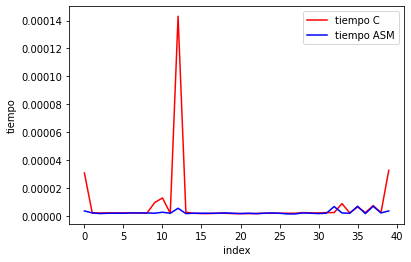

In [19]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
plt.show()